## I. Introduction

**This notebook will explain the complete pipeline from loading data to predicting results, and it will explain how to build a type of waste recognizer from image to predict whether an image shows presence of ships.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10683.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10736.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10489.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10512.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10975.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10064.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10281.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10384.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10986.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10870.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10786.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10268.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10760.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10759.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_11008

## II. Libraries and variables

**Run the following cell to load the necessary packages. We are going to instantiate constant variables such as the BATCH_SIZE, IMAGE_SIZE and the number of EPOCHS.**

In [2]:
# Libraries
from zipfile import ZipFile
import shutil, os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard,LearningRateScheduler
import tensorflow as tf
import datetime

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64 #16 * strategy.num_replicas_in_sync
SHUFFLE_SIZE = 3000
IMAGE_SIZE = [150, 150]
EPOCHS = 10

## III. Load the dataset

**The Ships data come with only one directory. You can find the datasets on this page by clicking on this link. We are going to use train_test_split from sklearn.model_selection in order to divide this dataset into 3 datasets (train, validation, test). We are going to take into consideration this proportion 80:10:10 in the division process.**

In [4]:
# Load the data
filenames = tf.io.gfile.glob(str('/kaggle/input/waste-classification-data/DATASET/TRAIN/*/*'))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.112)
test_filenames = tf.io.gfile.glob(str('/kaggle/input/waste-classification-data/DATASET/TEST/*/*'))
print(len(train_filenames),len(val_filenames),len(test_filenames))

20036 2528 2513


In [5]:
# Organic images count
NB_ORGANIC = len([name for name in train_filenames if "O" in name])
print("Organic waste images count in training set: " + str(NB_ORGANIC))

# Recyclable images count
NB_RECYCLABLE = len([name for name in train_filenames if "R" in name])
print("Recyclable waste images count in training set: " + str(NB_RECYCLABLE))

Organic waste images count in training set: 11135
Recyclable waste images count in training set: 20036


In [6]:
# Creating datasets
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'/kaggle/input/waste-classification-data/DATASET/TRAIN/O/O_6091.jpg'
b'/kaggle/input/waste-classification-data/DATASET/TRAIN/O/O_9003.jpg'
b'/kaggle/input/waste-classification-data/DATASET/TRAIN/R/R_7964.jpg'
b'/kaggle/input/waste-classification-data/DATASET/TRAIN/O/O_303.jpg'
b'/kaggle/input/waste-classification-data/DATASET/TRAIN/R/R_5507.jpg'


**The code in the following cell count the number of images we have in our training and validation dataset. We can then verify that the ratio of images is 80:10:10.**

In [7]:
# Training images count
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

# Validation images count
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 20036
Validating images count: 2528


(-0.5, 299.5, 149.5, -0.5)

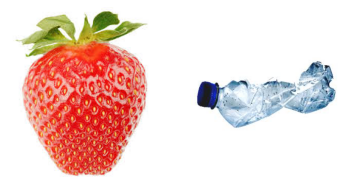

In [8]:
import matplotlib.image as mpimg
img1=mpimg.imread('/kaggle/input/waste-classification-data/DATASET/TRAIN/O/O_1.jpg')
img2=mpimg.imread('/kaggle/input/waste-classification-data/DATASET/TRAIN/R/R_10.jpg')
plt.subplot(1, 2, 1)    
plt.imshow(img1) 
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')

In [9]:
# Class names
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str('/kaggle/input/waste-classification-data/DATASET/TRAIN/*'))])

CLASS_NAMES

array(['R', 'O'], dtype='<U1')

**As demonstrated previously, the dataset is just a list of filenames which we want to map to tuple (image, label).** 

**The following function will first overwrite the labels by transforming Organic to 1 (True) and Recyclable to 0 (False)**

**Then, we will preprocess the images by converting its type, resizing it and may be trying some data augmentation techniques.**

In [10]:
def get_label(file_path):
    
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "O"

def image_processing(file_path):
    
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size
    img = tf.image.resize(img, IMAGE_SIZE)
    
    return img, label

In [11]:
# Mapped trainset
train_ds = train_list_ds.map(image_processing, num_parallel_calls=AUTOTUNE)

# Mapped Validationset
val_ds = val_list_ds.map(image_processing, num_parallel_calls=AUTOTUNE)

# Shape and label for one image
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (150, 150, 3)
Label:  True


In [12]:
# Load and format testset
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(image_processing, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print("Testing images count: " + str(TEST_IMAGE_COUNT))

Testing images count: 2513


**The code below will load the datasets only once and keep it in memory because it is small.**

**Then, we will shuffle it, repeat the process in order to keep give data to the model for training.**

**We will also batch it and use prefetch to add batches to the background while the model is training.**

In [13]:
# This is a small dataset, only load it once, and keep it in memory.
# Shuffle it and repeat forever
# Batch the dataset
# `prefetch` lets the dataset fetch batches in the background while the model is training.
train_ds = train_ds.cache().shuffle(SHUFFLE_SIZE).repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.cache().shuffle(SHUFFLE_SIZE).repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)

image_batch, label_batch = next(iter(train_ds))

## IV. Visualize the first batch

**This function will show the first batch of images stored in the trainset.**

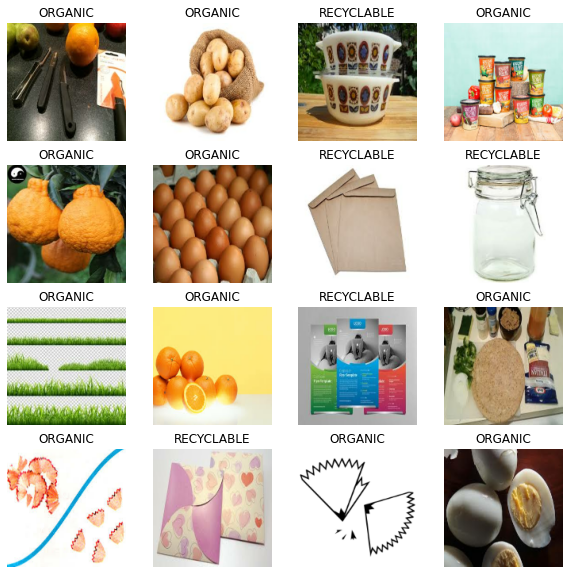

In [14]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("ORGANIC")
        else:
            plt.title("RECYCLABLE")
        plt.axis("off")
        
# Visualize the first batch
show_batch(image_batch.numpy(), label_batch.numpy())

## V. Correct the data

In [15]:
initial_bias = np.log([NB_ORGANIC/NB_RECYCLABLE])
initial_bias

array([-0.58743735])

In [16]:
weight_for_0 = (1 / NB_RECYCLABLE)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / NB_ORGANIC)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 0.90


## VI. Train the model

**Since there are only two possible labels for the image, we will be using the binary_crossentropy loss. When we fit the model, identify the class weights. Because we are using a TPU, training will be relatively quick.**

**For our metrics, we want to include precision and recall as they will provide use with a more informed picture of how good our model is. Accuracy tells us what fractions are the labels are correct. Since our data is not balanced, accuracy might give a skewed sense of a good model (i.e. a model that always predicts other will be 74% accurate but is not a good model).**

**Precision is the number of true positives (TP) over the sum of TP and false positives (FP). It shows what fraction of labeled positives are actually correct.**

**Recall is the number of TP over the sum of TP and false negatves (FN). It shows what fraction of actual positives are correct.**

In [17]:
# Modeling
MODULE_HANDLE = "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4"
feature_extractor = hub.KerasLayer(MODULE_HANDLE, input_shape= (150,150) + (3,), output_shape=[1280], trainable=False)
model = Sequential([feature_extractor, Dense(1,activation='sigmoid')])

# Learning rate decay / scheduling
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam")
rmsprop = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name="RMSprop")

# Metrics
METRICS = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

# Model Compile
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=METRICS)

# Callbacks functions
logdir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
rLRop = ReduceLROnPlateau(monitor="val_accuracy", factor=0.8, patience=3, verbose=1, mode="auto", min_lr=0.000001)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1, write_graph=True, write_images=False, update_freq="batch", profile_batch=0,
                          embeddings_freq=0,embeddings_metadata=None)

In [18]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              42626560  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 42,628,609
Trainable params: 2,049
Non-trainable params: 42,626,560
_________________________________________________________________


In [19]:
# Model fit function
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/10
313/313 [==============================] - 73s 234ms/step - loss: 0.1735 - accuracy: 0.8937 - precision: 0.8798 - recall: 0.9368 - val_loss: 0.1760 - val_accuracy: 0.9359 - val_precision: 0.9219 - val_recall: 0.9689
Epoch 2/10
313/313 [==============================] - 33s 105ms/step - loss: 0.1146 - accuracy: 0.9339 - precision: 0.9257 - recall: 0.9579 - val_loss: 0.1635 - val_accuracy: 0.9391 - val_precision: 0.9263 - val_recall: 0.9695
Epoch 3/10
313/313 [==============================] - 33s 106ms/step - loss: 0.1036 - accuracy: 0.9383 - precision: 0.9312 - recall: 0.9600 - val_loss: 0.1570 - val_accuracy: 0.9379 - val_precision: 0.9250 - val_recall: 0.9689
Epoch 4/10
313/313 [==============================] - 33s 106ms/step - loss: 0.0971 - accuracy: 0.9430 - precision: 0.9358 - recall: 0.9636 - val_loss: 0.1578 - val_accuracy: 0.9359 - val_precision: 0.9200 - val_recall: 0.9709
Epoch 5/10
313/313 [==============================] - 33s 106ms/step - loss: 0.0927 - accura

## VII. Visualizing model performance

**Let's plot the model accuracy and loss for the training and the validating set. These plots show the accuracy and loss values of training.****

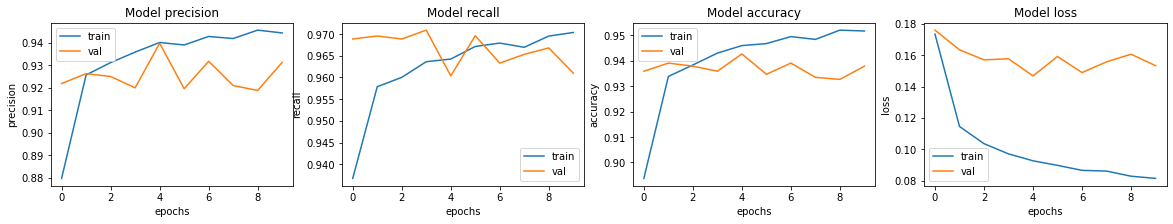

In [20]:
# Visualize model's performance
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## VIII. Predict and evaluate results

**Let's evaluate the model on our test data!**

In [21]:
# Predictions
loss, acc, prec, rec = model.evaluate(test_ds)

40/40 [==============================] - 8s 198ms/step - loss: 0.2983 - accuracy: 0.8957 - precision: 0.8566 - recall: 0.9764
